In [1]:
from dragonnet import DragonNet
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

road='/data/home/baldwinhe/revenue_uplift/datasets/Hillstrom'# 数据存放的地址


In [2]:
%time train_df =  pd.read_pickle(road + '/dt_binary_men_train.pkl')
%time test_df =  pd.read_pickle(road + '/dt_binary_men_test.pkl')

CPU times: user 0 ns, sys: 3.56 ms, total: 3.56 ms
Wall time: 2.88 ms
CPU times: user 1.06 ms, sys: 265 µs, total: 1.32 ms
Wall time: 1.28 ms


In [3]:
in_features = ['recency', 'history_segment', 'mens', 'womens',
       'zip_code', 'newbie', 'channel_Multichannel', 'channel_Phone', 'channel_Web']
label_feature = ['spend']
treatment_feature = ['CASE']

In [4]:
X_train = train_df[in_features].values.astype(float)
y_train = train_df[label_feature].values.astype(float)
t_train = train_df[treatment_feature].values.astype(float)

X_test = test_df[in_features].values.astype(float)
y_test = test_df[label_feature].values.astype(float)
t_test = test_df[treatment_feature].values.astype(float)

In [5]:
print('X_train[:10]', X_train[:10].astype(float))

X_train[:10] [[5. 4. 0. 1. 2. 1. 0. 1. 0.]
 [4. 4. 1. 0. 1. 1. 0. 0. 1.]
 [4. 1. 0. 1. 1. 1. 0. 0. 1.]
 [2. 0. 1. 0. 0. 1. 0. 0. 1.]
 [2. 0. 1. 0. 1. 1. 0. 0. 1.]
 [1. 6. 1. 1. 2. 1. 0. 0. 1.]
 [4. 0. 1. 0. 0. 0. 0. 0. 1.]
 [5. 4. 0. 1. 1. 1. 0. 0. 1.]
 [4. 5. 1. 0. 0. 1. 0. 1. 0.]
 [2. 3. 0. 1. 2. 1. 0. 0. 1.]]


In [6]:
model = DragonNet(X_train.shape[1], epochs=25)
model.fit(X_train, y_train, t_train)
y0_pred, y1_pred, t_pred, _ = model.predict(X_test)

epoch: 0--------- train_loss: 14080756.0
epoch: 1--------- train_loss: 14067212.0
epoch: 2--------- train_loss: 14061940.0
epoch: 3--------- train_loss: 14054010.0
epoch: 4--------- train_loss: 14045628.0
epoch: 5--------- train_loss: 14037430.0
epoch: 6--------- train_loss: 14028384.0
epoch: 7--------- train_loss: 14018456.0
epoch: 8--------- train_loss: 14009732.0
epoch: 9--------- train_loss: 14004956.0
epoch: 10--------- train_loss: 14004037.0
epoch: 11--------- train_loss: 14004700.0
epoch: 12--------- train_loss: 14004710.0
epoch: 13--------- train_loss: 14001240.0
epoch: 14--------- train_loss: 13996453.0
epoch: 15--------- train_loss: 13992577.0
epoch: 16--------- train_loss: 13989214.0
epoch: 17--------- train_loss: 13986604.0
epoch: 18--------- train_loss: 13984948.0
epoch: 19--------- train_loss: 13983415.0
epoch: 20--------- train_loss: 13981576.0
epoch: 21--------- train_loss: 13979778.0
epoch: 22--------- train_loss: 13977892.0
epoch: 23--------- train_loss: 13975658.0
ep

In [7]:
test_df['target_dif'] = y1_pred - y0_pred

In [8]:
def get_new_df(df, uplift_val, treatment_feature, label_feature):
    new_df = pd.DataFrame(columns = [treatment_feature[0], label_feature[0], uplift_val])
    new_df[treatment_feature[0]] = df[treatment_feature[0]]
    new_df[label_feature[0]] = df[label_feature[0]]
    new_df[uplift_val] = df[uplift_val]
    return new_df
    
def auuc_metric(data, uplift_val, bucket_num, treatment_feature, label_feature, if_return = True, final_test = False):
    print('label_feature',label_feature)
    new_data = get_new_df(data, uplift_val, treatment_feature, label_feature)
    if final_test:
        del data
    new_data = new_data.sort_values(by=uplift_val, ascending = False)
    print(bucket_num)
    new_data['bucket'] = pd.qcut(-new_data[uplift_val], bucket_num, labels=False, duplicates='drop')
    print('====计算完毕====')
    print('====生成随机数====')
    new_data = new_data.sort_values(by=treatment_feature)
    
    l0, l1 = new_data.loc[new_data[treatment_feature[0]]==0], new_data.loc[new_data[treatment_feature[0]]==1]
    mean0, mean1 = l0[label_feature].values.mean(), l1[label_feature].values.mean()
    print('treatment = 0:', mean0, 'treatment = 1:', mean1)
    r0, r1 = (np.random.rand(len(l0)) - 0.5)/100000 + mean0, (np.random.rand(len(l1)) - 0.5)/100000 + mean1
    print(type(r0))
    new_data['random'] = r0.tolist() + r1.tolist()
    bucket_diff = []
    print(set(new_data.bucket))
    print('=========')
    for i in set(new_data.bucket):
        mean_treat = np.mean(new_data.loc[(new_data.bucket == i)&(new_data[treatment_feature[0]] == 1), label_feature].values)
        mean_control = np.mean(new_data.loc[(new_data.bucket == i)&(new_data[treatment_feature[0]] == 0), label_feature].values)
        bucket_diff.append(mean_treat / mean_control - 1)
    plt.ylabel('diff of '+label_feature[0])
    plt.bar(range(len(bucket_diff)),bucket_diff)
    plt.show()
    
    res, population, rand_res, bucket_len = [], [], [], []
    for i in np.arange(0, len(set(new_data.bucket)), 1):
        dbucket = new_data.loc[new_data.bucket <= i]
        db_base = dbucket.loc[dbucket[treatment_feature[0]] == 0]
        db_exp = dbucket.loc[dbucket[treatment_feature[0]] == 1]
        cumugain = (db_exp[label_feature].mean() / db_base[label_feature].mean() - 1) * (len(db_base) + len(db_exp))
        cumu_random = (db_exp['random'].mean() / db_base['random'].mean()- 1 ) * (len(db_base) + len(db_exp))
        population.append(len(db_base) + len(db_exp))
        bucket_len.append(len(new_data[new_data.bucket == i]))
        res.append(cumugain)
        rand_res.append(cumu_random)
    rand_res[-1] = res[-1]
    cumuGain = pd.DataFrame({'cumuGain': res,
                             'population': population,
                             'percent': np.arange(1 / len(set(new_data.bucket)), 1 + 1 / len(set(new_data.bucket)),
                                                  1 / len(set(new_data.bucket))),
                             'random': rand_res})
    
    # 归一化 将值框定在[0，1]之间
    cumugain = cumuGain['cumuGain']
    gap0 = cumugain.iloc[-1].values
    cumugain = [(i) / abs(gap0) for i in cumugain]

    cumu_random = cumuGain['random']
    gap = cumu_random.iloc[-1]
    cumu_random = [(i) / abs(gap) for i in cumu_random]
    
    plt.plot(np.append(0,(np.array(population))/max(population)), np.append(0,cumugain), marker='*', label='pred')
    plt.plot(np.append(0,(np.array(population))/max(population)), np.append(0,cumu_random), marker='*', label='random')
    plt.grid(linestyle='--')
    plt.xlabel('Percent')
    plt.ylabel('Uplift')
    plt.legend()
    plt.show()
    
    # 近似计算cumugain函数和x轴围成的曲线下面积，也就是auuc
    auuc_value, rand = np.trapz(np.append(0, cumugain),np.append(0, (np.array(population))/max(population))),\
                                np.trapz(np.append(0, cumu_random),np.append(0, (np.array(population))/max(population)))
    print('raw auuc score', auuc_value)
    auuc_value = auuc_value - rand
    spearmanr_value = -scipy.stats.spearmanr(bucket_diff, list(set(new_data.bucket)))[0]
    print(cumugain, np.array(population)/max(population))
    if gap0 < 0: 
        auuc_value, rand = np.trapz([i + 1 for i in np.append(0, cumugain)], np.append(0,(np.array(population))/max(population))),\
                                    np.trapz([i + 1 for i in np.append(0, cumu_random)], np.append(0,(np.array(population))/max(population)))
        auuc_value = auuc_value - rand
    print('auuc score:', auuc_value, 'random score:', rand)
    print('spearmanr:', spearmanr_value)
    if if_return == True:return data
    else: return auuc_value

label_feature ['spend']
100
====计算完毕====
====生成随机数====
treatment = 0: 0.6284856519026824 treatment = 1: 1.360861581920904
<class 'numpy.ndarray'>
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}


/tmp/ipykernel_2608480/1931488437.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  bucket_diff.append(mean_treat / mean_control - 1)
/tmp/ipykernel_2608480/1931488437.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  bucket_diff.append(mean_treat / mean_control - 1)
/tmp/ipykernel_2608480/1931488437.py:32: RuntimeWarning: invalid value encountered in scalar divide
  bucket_diff.append(mean_treat / mean_control - 1)
/tmp/ipykernel_2608480/1931488437.py:32: RuntimeWarning: invalid value encountered in scalar divide
  bucket_diff.append(mean_treat / mean_control - 1)
/tmp/ipykernel_2608480/1931488437.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  bucket_diff.append(mean_treat / mean_control - 1)
/tmp/ipykernel_2608480/1931488437.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  bucket_diff.append(mean_treat / mean_control - 1)
/tmp/ipykernel_2608480/1931488437.py:32: RuntimeWarning: divide by zero encountered 

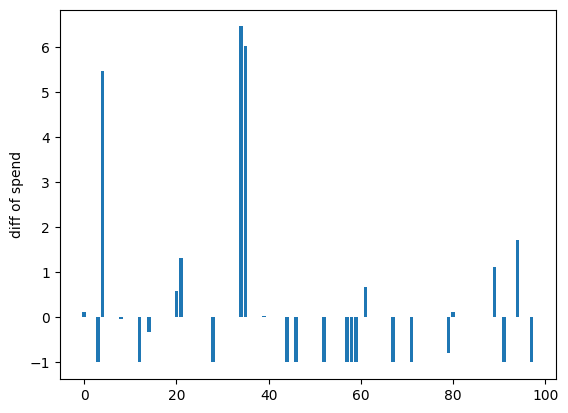

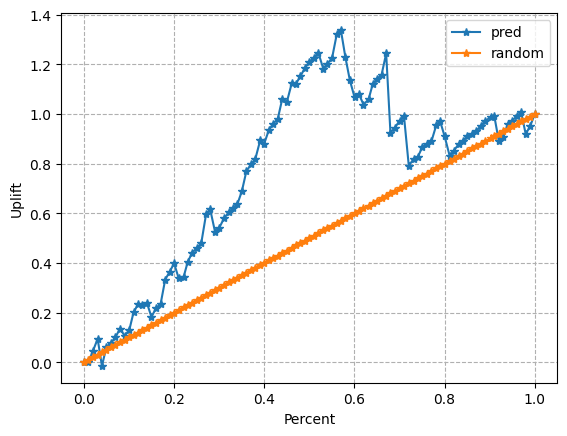

raw auuc score 0.7610445955551282
[spend    0.001144
dtype: float64, spend    0.046257
dtype: float64, spend    0.094575
dtype: float64, spend   -0.014433
dtype: float64, spend    0.062215
dtype: float64, spend    0.078417
dtype: float64, spend    0.100756
dtype: float64, spend    0.136001
dtype: float64, spend    0.10721
dtype: float64, spend    0.129509
dtype: float64, spend    0.200787
dtype: float64, spend    0.233265
dtype: float64, spend    0.23163
dtype: float64, spend    0.23776
dtype: float64, spend    0.182844
dtype: float64, spend    0.219212
dtype: float64, spend    0.233516
dtype: float64, spend    0.33322
dtype: float64, spend    0.364655
dtype: float64, spend    0.398523
dtype: float64, spend    0.340981
dtype: float64, spend    0.345212
dtype: float64, spend    0.404031
dtype: float64, spend    0.442096
dtype: float64, spend    0.460365
dtype: float64, spend    0.479454
dtype: float64, spend    0.598301
dtype: float64, spend    0.615716
dtype: float64, spend    0.525058

0.26104445422794953

In [9]:
auuc_metric(test_df,'target_dif', 100, treatment_feature, label_feature, if_return = False)